In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Veri setini yükle
df = pd.read_csv("dataset_clean.csv")

print(df.shape)
df.head()


(71493, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,20001,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,...,-7.375,1,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,dance
1,51664,2tTmW7RDtMQtBk7m2rYeSw,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52","Quevedo: Bzrp Music Sessions, Vol. 52",99,198937,False,0.621,0.782,...,-5.548,1,0.0440,0.01250,0.033000,0.2300,0.550,128.033,4,hip-hop
2,81210,4uUG5RXrOk84mYEfFvj3cK,David Guetta;Bebe Rexha,I'm Good (Blue),I'm Good (Blue),98,175238,True,0.561,0.965,...,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,4,pop
3,89411,5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,La Bachata,98,162637,False,0.835,0.679,...,-5.329,0,0.0364,0.58300,0.000002,0.2180,0.850,124.980,4,reggaeton
4,68305,6Sq7ltF9Qa7SNFBsV5Cogx,Bad Bunny;Chencho Corleone,Un Verano Sin Ti,Me Porto Bonito,97,178567,True,0.911,0.712,...,-5.105,0,0.0817,0.09010,0.000027,0.0933,0.425,92.005,4,latino


In [3]:
# Hedef değişken
target_col = "popularity"

# Audio + temel numeric feature'lar
base_numeric_features = [
    "duration_ms",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
]

# Kategorik feature'lar
categorical_features = ["track_genre"]


In [4]:
# Model için kullanılacak temel X (artists dahil, çünkü artist feature üreteceğiz)
X_base = df[base_numeric_features + categorical_features + ["artists"]].copy()
y = df[target_col].copy()

# Train / temp (train %70)
X_train_base, X_temp_base, y_train, y_temp = train_test_split(
    X_base, y, test_size=0.30, random_state=42
)

# Temp → Val / Test (val %15, test %15)
X_val_base, X_test_base, y_val, y_test = train_test_split(
    X_temp_base, y_temp, test_size=0.50, random_state=42
)

print("Train:", X_train_base.shape)
print("Val  :", X_val_base.shape)
print("Test :", X_test_base.shape)


Train: (50045, 15)
Val  : (10724, 15)
Test : (10724, 15)


## ⚠️ Data Leakage Düzeltmesi

**Problem:** Önceki versiyonda artist istatistikleri (mean, median, max, std) tüm veri setinden hesaplanıyordu. Bu, test ve validation setlerindeki şarkıların popülerlik bilgisinin train setine sızmasına neden oluyordu.

**Çözüm:** Artist istatistikleri artık **sadece train seti** üzerinden hesaplanıyor. Val ve test setlerinde train'de olmayan artist'ler için NaN değerleri global istatistiklerle doldurulacak.

Bu düzeltme sonrası model performansı daha gerçekçi olacak (RMSE artabilir, ama bu doğru ölçüm).

In [5]:
# ⚠️ DATA LEAKAGE DÜZELTMESİ:
# Artist popülerlik istatistiklerini SADECE TRAIN SET ÜZERİNDEN hesaplıyoruz
# (Yoksa test/val setlerindeki şarkıların popülerlik bilgisi train'e sızıyor)

# X_train_base index'lerini kullanarak sadece train satırlarını alıyoruz
train_df_for_artist = df.loc[X_train_base.index, ["artists", "popularity"]].copy()

artist_stats_train = train_df_for_artist.groupby("artists")["popularity"].agg(
    artist_pop_mean="mean",
    artist_pop_median="median",
    artist_pop_max="max",
    artist_pop_std="std",

    artist_track_count="count",

).reset_index()

artist_stats_train.head()
print(f"Train setinde {len(artist_stats_train)} unique artist var.")

Train setinde 21888 unique artist var.


In [6]:
artist_feature_cols = [
    "artist_pop_mean",
    "artist_pop_median",
    "artist_pop_max",
    "artist_pop_std",
    "artist_track_count",
]

def merge_artist_features(X):
    # SADECE train'den hesaplanan istatistikleri kullan
    # Val/test setlerinde yeni artist'ler varsa NaN olacak (sonra doldurulacak)
    return X.merge(artist_stats_train, on="artists", how="left")

X_train = merge_artist_features(X_train_base)
X_val   = merge_artist_features(X_val_base)
X_test  = merge_artist_features(X_test_base)


print(f"\nTrain set - NaN sayısı: {X_train[artist_feature_cols].isna().sum().sum()}")
print(f"Val set - NaN sayısı: {X_val[artist_feature_cols].isna().sum().sum()}")
print(f"Test set - NaN sayısı: {X_test[artist_feature_cols].isna().sum().sum()}")

X_train.head()


Train set - NaN sayısı: 15013
Val set - NaN sayısı: 17211
Test set - NaN sayısı: 16905


,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,artists,artist_pop_mean,artist_pop_median,artist_pop_max,artist_pop_std,artist_track_count
0,278453,0.608,0.834,6,-5.101,0,0.0381,0.021800,0.000164,0.130,0.855,139.993,4,power-pop,Ex Hex,22.666667,22.0,25,2.081666,3
1,37616,0.203,0.900,6,-5.535,1,0.0949,0.000004,0.946000,0.374,0.431,108.132,5,grindcore,Miasmatic Necrosis,13.700000,13.0,18,2.451757,10
2,117440,0.586,0.559,9,-12.150,1,0.0914,0.234000,0.000000,0.297,0.819,133.181,4,swedish,Mörbyligan,39.000000,39.0,43,5.656854,2
3,299881,0.424,0.746,4,-2.904,0,0.0651,0.455000,0.000000,0.565,0.239,92.339,4,salsa,Grupo Niche,29.916667,29.5,36,2.712206,12
4,203576,0.679,0.455,7,-8.174,0,0.3820,0.049200,0.004050,0.284,0.838,134.810,3,dancehall,Burna Boy,54.142857,58.0,83,23.124199,21


In [7]:
# ⚠️ Fallback değerleri de SADECE TRAIN'den hesaplanmalı (data leakage önlemi)
global_means = train_df_for_artist["popularity"].agg(
    mean="mean",
    median="median",
    max="max",
    std="std",
)

for col in artist_feature_cols:
    if "mean" in col:
        fill_val = global_means["mean"]
    elif "median" in col:
        fill_val = global_means["median"]
    elif "max" in col:
        fill_val = global_means["max"]
    elif "std" in col:
        fill_val = global_means["std"]
    else:  # artist_track_count
        fill_val = 1.0

    X_train[col].fillna(fill_val, inplace=True)
    X_val[col].fillna(fill_val, inplace=True)
    X_test[col].fillna(fill_val, inplace=True)


/var/folders/hs/j2t0cb3j02n7jvt7qnfzv4lc0000gn/T/ipykernel_18433/4265963099.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(fill_val, inplace=True)
/var/folders/hs/j2t0cb3j02n7jvt7qnfzv4lc0000gn/T/ipykernel_18433/4265963099.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [8]:
# Son numeric feature listesi: audio + artist level
numeric_features = base_numeric_features + artist_feature_cols

# Modelde 'artists' kolonu kullanılmayacak
X_train_model = X_train.drop(columns=["artists"])
X_val_model   = X_val.drop(columns=["artists"])
X_test_model  = X_test.drop(columns=["artists"])

X_train_model.head()


,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,artist_pop_mean,artist_pop_median,artist_pop_max,artist_pop_std,artist_track_count
0,278453,0.608,0.834,6,-5.101,0,0.0381,0.021800,0.000164,0.130,0.855,139.993,4,power-pop,22.666667,22.0,25,2.081666,3
1,37616,0.203,0.900,6,-5.535,1,0.0949,0.000004,0.946000,0.374,0.431,108.132,5,grindcore,13.700000,13.0,18,2.451757,10
2,117440,0.586,0.559,9,-12.150,1,0.0914,0.234000,0.000000,0.297,0.819,133.181,4,swedish,39.000000,39.0,43,5.656854,2
3,299881,0.424,0.746,4,-2.904,0,0.0651,0.455000,0.000000,0.565,0.239,92.339,4,salsa,29.916667,29.5,36,2.712206,12
4,203576,0.679,0.455,7,-8.174,0,0.3820,0.049200,0.004050,0.284,0.838,134.810,3,dancehall,54.142857,58.0,83,23.124199,21


In [9]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [10]:
def evaluate_regression(y_true, y_pred, name="Model"):
    import numpy as np
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"=== {name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R^2 : {r2:.4f}")
    print()
    
    return {"name": name, "rmse": rmse, "mae": mae, "r2": r2}


In [11]:
rf_with_artist = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", RandomForestRegressor(
            random_state=42,
            n_jobs=-1,
            max_depth=None,
            min_samples_leaf=2,
            min_samples_split=5,
            n_estimators=200,
        )),
    ]
)

rf_with_artist.fit(X_train_model, y_train)

y_val_pred_rf_artist = rf_with_artist.predict(X_val_model)
rf_artist_val_metrics = evaluate_regression(
    y_val, y_val_pred_rf_artist, name="RF + Artist (Val, Full Stats)"
)

rf_artist_val_metrics


=== RF + Artist (Val, Full Stats) ===
RMSE: 14.2518
MAE : 9.2815
R^2 : 0.4240



{'name': 'RF + Artist (Val, Full Stats)',
 'rmse': 14.251764034037905,
 'mae': 9.28150125222883,
 'r2': 0.423956507233584}

In [12]:
# Train + Val'i birleştir
X_train_full_model = pd.concat([X_train_model, X_val_model], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

final_rf_artist = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", RandomForestRegressor(
            random_state=42,
            n_jobs=-1,
            max_depth=None,
            min_samples_leaf=2,
            min_samples_split=5,
            n_estimators=200,
        )),
    ]
)

final_rf_artist.fit(X_train_full_model, y_train_full)

y_test_pred_rf_artist = final_rf_artist.predict(X_test_model)
rf_artist_test_metrics = evaluate_regression(
    y_test, y_test_pred_rf_artist, name="FINAL RF + Artist (Test, Full Stats)"
)

rf_artist_test_metrics


=== FINAL RF + Artist (Test, Full Stats) ===
RMSE: 12.2241
MAE : 7.7373
R^2 : 0.5584



{'name': 'FINAL RF + Artist (Test, Full Stats)',
 'rmse': 12.224090072304211,
 'mae': 7.737320742458203,
 'r2': 0.5584225539293031}

In [13]:
# Linear Regression Model with Artist Features
from sklearn.linear_model import LinearRegression

lr_with_artist = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

lr_with_artist.fit(X_train_model, y_train)

y_val_pred_lr_artist = lr_with_artist.predict(X_val_model)
lr_artist_val_metrics = evaluate_regression(
    y_val, y_val_pred_lr_artist, name="Linear Regression + Artist (Val)"
)

lr_artist_val_metrics

=== Linear Regression + Artist (Val) ===
RMSE: 14.3148
MAE : 9.4249
R^2 : 0.4188



{'name': 'Linear Regression + Artist (Val)',
 'rmse': 14.314840670635904,
 'mae': 9.424908035547759,
 'r2': 0.4188462215252864}

In [14]:
# Model sonuçları özeti
print("=" * 80)
print("📊 MODEL SONUÇLARI - VALIDATION SET")
print("=" * 80)
print(f"\n✅ Linear Regression + Artist Features:")
print(f"   RMSE: {lr_artist_val_metrics['rmse']:.2f}")
print(f"   R²:   {lr_artist_val_metrics['r2']:.3f}")
print(f"\n✅ Random Forest + Artist Features:")
print(f"   RMSE: {rf_artist_val_metrics['rmse']:.2f}")
print(f"   R²:   {rf_artist_val_metrics['r2']:.3f}")
print("=" * 80)


📊 MODEL SONUÇLARI - VALIDATION SET

✅ Linear Regression + Artist Features:
   RMSE: 14.31
   R²:   0.419

✅ Random Forest + Artist Features:
   RMSE: 14.25
   R²:   0.424


In [15]:
# Final Linear Regression on Test Set
final_lr_artist = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

final_lr_artist.fit(X_train_full_model, y_train_full)

y_test_pred_lr_artist = final_lr_artist.predict(X_test_model)
lr_artist_test_metrics = evaluate_regression(
    y_test, y_test_pred_lr_artist, name="FINAL Linear Regression + Artist (Test)"
)

lr_artist_test_metrics

=== FINAL Linear Regression + Artist (Test) ===
RMSE: 13.1656
MAE : 8.6881
R^2 : 0.4878



{'name': 'FINAL Linear Regression + Artist (Test)',
 'rmse': 13.165571503858644,
 'mae': 8.68806741776316,
 'r2': 0.48778389072692496}

In [16]:
# XGBoost Model with Artist Features
from xgboost import XGBRegressor

xgb_with_artist = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1,
            tree_method="hist"
        ))
    ]
)

xgb_with_artist.fit(X_train_model, y_train)

y_val_pred_xgb_artist = xgb_with_artist.predict(X_val_model)
xgb_artist_val_metrics = evaluate_regression(
    y_val, y_val_pred_xgb_artist, name="XGBoost + Artist (Val)"
)

xgb_artist_val_metrics

=== XGBoost + Artist (Val) ===
RMSE: 20.0060
MAE : 12.8156
R^2 : -0.1351



{'name': 'XGBoost + Artist (Val)',
 'rmse': 20.005953415893277,
 'mae': 12.815569447217483,
 'r2': -0.13510630281374847}

In [17]:
# XGBoost with GridSearchCV for Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

xgb_base = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_estimators=300,
            n_jobs=-1,
            tree_method="hist"
        ))
    ]
)

param_grid_xgb = {
    "regressor__max_depth": [4, 6],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__subsample": [0.8, 1.0],
    "regressor__colsample_bytree": [0.8, 1.0],
}

xgb_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

xgb_search.fit(X_train_model, y_train)

print("En iyi XGB parametreleri:", xgb_search.best_params_)
print("XGB CV (best) RMSE:", -xgb_search.best_score_)

best_xgb_artist = xgb_search.best_estimator_

y_val_pred_xgb_tuned = best_xgb_artist.predict(X_val_model)
xgb_tuned_val_metrics = evaluate_regression(
    y_val, y_val_pred_xgb_tuned, name="XGBoost + Artist (Val, Tuned)"
)

xgb_tuned_val_metrics

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__max_depth=4, regressor__subsample=0.8; total time=   0.9s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__max_depth=4, regressor__subsample=0.8; total time=   0.9s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__max_depth=4, regressor__subsample=1.0; total time=   0.9s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__max_depth=4, regressor__subsample=1.0; total time=   1.0s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__max_depth=4, regressor__subsample=0.8; total time=   1.1s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.05, regressor__max_depth=4, regressor__subsample=1.0; total time=   0.9s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.1, regressor__max_

{'name': 'XGBoost + Artist (Val, Tuned)',
 'rmse': 21.298744474588055,
 'mae': 13.741425522254847,
 'r2': -0.2865481221929773}

In [18]:
# Final XGBoost on Test Set
final_xgb_artist = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1,
            tree_method="hist",
            **{k.replace("regressor__", ""): v for k, v in xgb_search.best_params_.items()}
        ))
    ]
)

final_xgb_artist.fit(X_train_full_model, y_train_full)

y_test_pred_xgb_artist = final_xgb_artist.predict(X_test_model)
xgb_artist_test_metrics = evaluate_regression(
    y_test, y_test_pred_xgb_artist, name="FINAL XGBoost + Artist (Test)"
)

xgb_artist_test_metrics

=== FINAL XGBoost + Artist (Test) ===
RMSE: 13.0379
MAE : 8.5925
R^2 : 0.4977



{'name': 'FINAL XGBoost + Artist (Test)',
 'rmse': 13.03787079593507,
 'mae': 8.592453624621376,
 'r2': 0.4976722776844764}

In [19]:
# Model Comparison on Validation Set
results = []

# Linear Regression
results.append(lr_artist_val_metrics)

# Random Forest
results.append(rf_artist_val_metrics)

# XGBoost (Basic)
results.append(xgb_artist_val_metrics)

# XGBoost (Tuned)
results.append(xgb_tuned_val_metrics)

results_df = pd.DataFrame(results)
results_df.sort_values(by="rmse")

,name,rmse,mae,r2
1,"RF + Artist (Val, Full Stats)",14.251764,9.281501,0.423957
0,Linear Regression + Artist (Val),14.314841,9.424908,0.418846
2,XGBoost + Artist (Val),20.005953,12.815569,-0.135106
3,"XGBoost + Artist (Val, Tuned)",21.298744,13.741426,-0.286548


In [20]:
# Final Model Comparison on Test Set
test_results = []

# Linear Regression
test_results.append(lr_artist_test_metrics)

# Random Forest
test_results.append(rf_artist_test_metrics)

# XGBoost (if available)
try:
    test_results.append(xgb_artist_test_metrics)
except NameError:
    print("XGBoost results not yet computed")

test_results_df = pd.DataFrame(test_results)
test_results_df.sort_values(by="rmse")

,name,rmse,mae,r2
1,"FINAL RF + Artist (Test, Full Stats)",12.224090,7.737321,0.558423
2,FINAL XGBoost + Artist (Test),13.037871,8.592454,0.497672
0,FINAL Linear Regression + Artist (Test),13.165572,8.688067,0.487784


## 📊 Model Görselleştirme ve Analiz

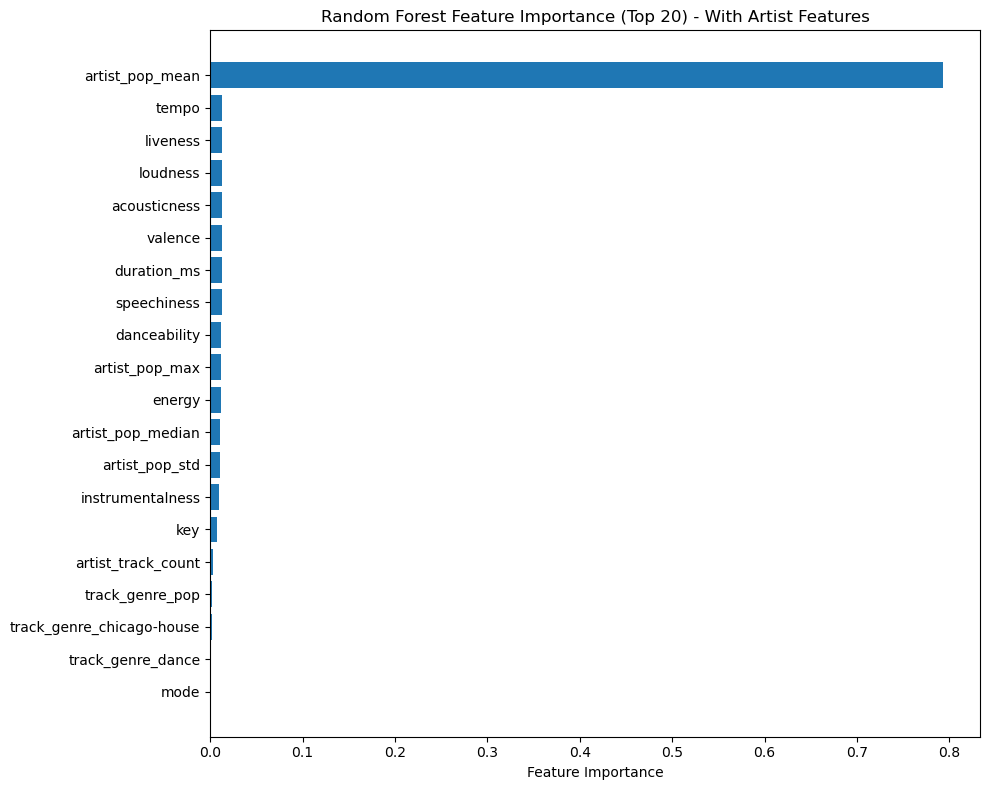

In [21]:
# Feature Importance for Random Forest Model
import matplotlib.pyplot as plt

# Pipeline içindeki parçaları çek
preprocess = final_rf_artist.named_steps["preprocess"]
rf_model = final_rf_artist.named_steps["regressor"]

# Numeric feature isimleri (artist features dahil)
num_features = numeric_features

# Kategorik feature'lar için OneHotEncoder'dan isimler
cat_encoder = preprocess.named_transformers_["cat"]
cat_features = list(cat_encoder.get_feature_names_out(categorical_features))

# Son feature listesi (preprocess sonrası)
feature_names = num_features + cat_features

# Importance değerleri
importances = rf_model.feature_importances_
importances = np.array(importances)

# En önemli 20 feature'ı seç
top_k = 20
idx = np.argsort(importances)[-top_k:]   # en büyük 20
top_importances = importances[idx]
top_names = np.array(feature_names)[idx]

# Daha okunur olsun diye sıralamayı tekrar düzelt (küçükten büyüğe)
order = np.argsort(top_importances)
top_importances = top_importances[order]
top_names = top_names[order]

plt.figure(figsize=(10, 8))
plt.barh(top_names, top_importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (Top 20) - With Artist Features")
plt.tight_layout()
plt.show()

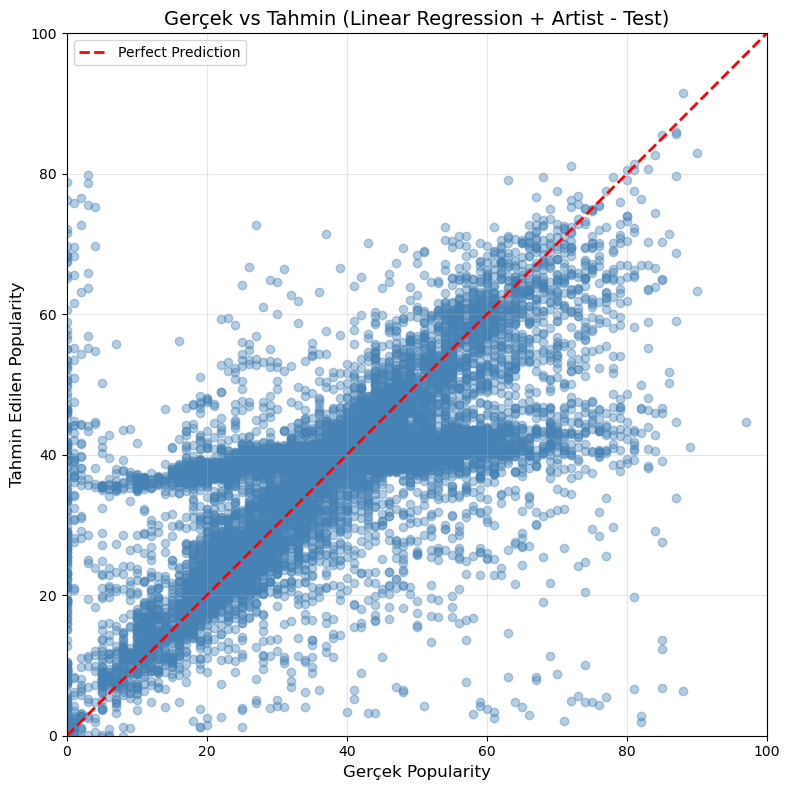

In [22]:
# Gerçek vs Tahmin Scatter Plot (Best Model - Linear Regression)
y_test_pred_best = y_test_pred_lr_artist

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred_best, alpha=0.4, color='steelblue')
plt.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel("Gerçek Popularity", fontsize=12)
plt.ylabel("Tahmin Edilen Popularity", fontsize=12)
plt.title("Gerçek vs Tahmin (Linear Regression + Artist - Test)", fontsize=14)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

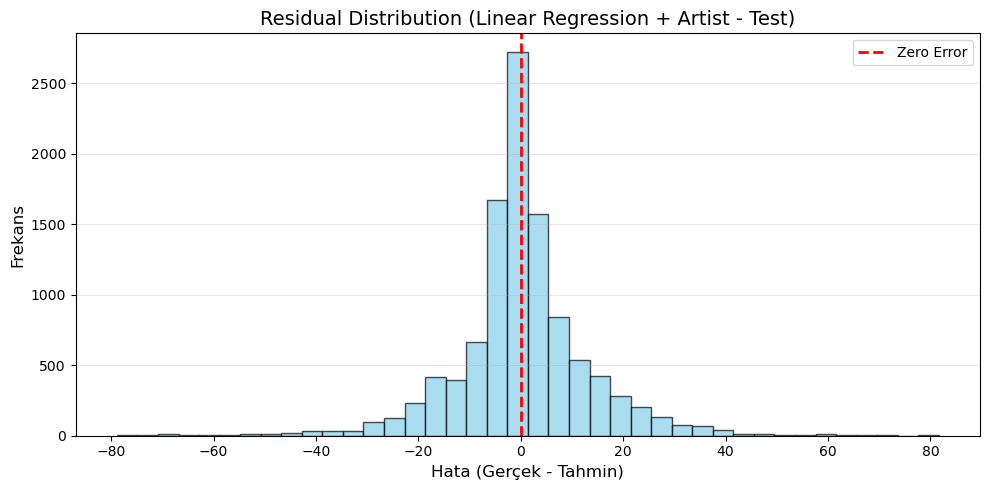

Residuals - Mean: 0.1992
Residuals - Std: 13.1647
Residuals - Min: -78.8937
Residuals - Max: 81.6514


In [23]:
# Residual Distribution (Hata Dağılımı)
residuals = y_test - y_test_pred_best

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=40, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.xlabel("Hata (Gerçek - Tahmin)", fontsize=12)
plt.ylabel("Frekans", fontsize=12)
plt.title("Residual Distribution (Linear Regression + Artist - Test)", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Residuals - Mean: {residuals.mean():.4f}")
print(f"Residuals - Std: {residuals.std():.4f}")
print(f"Residuals - Min: {residuals.min():.4f}")
print(f"Residuals - Max: {residuals.max():.4f}")

In [24]:
# Performance by Popularity Bins
test_df_eval = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_test_pred_best
})

test_df_eval["bin"] = pd.cut(
    test_df_eval["y_true"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0-20", "20-40", "40-60", "60-80", "80-100"]
)

group_stats = test_df_eval.groupby("bin").apply(
    lambda g: pd.Series({
        "RMSE": np.sqrt(np.mean((g["y_true"] - g["y_pred"])**2)),
        "MAE": np.mean(np.abs(g["y_true"] - g["y_pred"])),
        "R2": r2_score(g["y_true"], g["y_pred"]),
        "count": len(g)
    })
)

print("Performance by Popularity Range:")
group_stats

Performance by Popularity Range:


/var/folders/hs/j2t0cb3j02n7jvt7qnfzv4lc0000gn/T/ipykernel_18433/684461067.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = test_df_eval.groupby("bin").apply(
/var/folders/hs/j2t0cb3j02n7jvt7qnfzv4lc0000gn/T/ipykernel_18433/684461067.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_stats = test_df_eval.groupby("bin").apply(


,RMSE,MAE,R2,count
bin,,,,
0-20,15.044373,9.794610,-6.548353,1855.0
20-40,8.243583,5.848884,-0.815722,4106.0
40-60,10.363231,7.626536,-2.240414,3355.0
60-80,20.812090,16.279120,-14.431662,1076.0
80-100,38.140098,31.458139,-181.345353,74.0


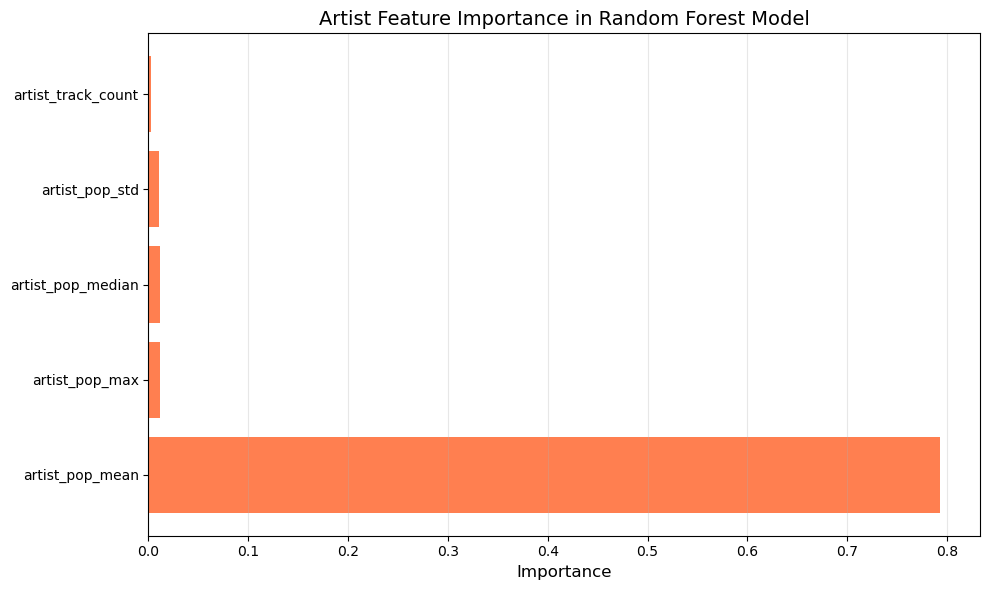


Artist Features Ranking:
artist_pop_mean: 0.7934
artist_pop_max: 0.0120
artist_pop_median: 0.0111
artist_pop_std: 0.0108
artist_track_count: 0.0028


In [26]:
# Artist Features Impact Analysis
artist_features_importance = {}
for i, name in enumerate(feature_names):
    if 'artist_' in name:
        artist_features_importance[name] = importances[i]

if artist_features_importance:
    sorted_artist_features = sorted(artist_features_importance.items(), key=lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(10, 6))
    names = [item[0] for item in sorted_artist_features]
    values = [item[1] for item in sorted_artist_features]
    
    plt.barh(names, values, color='coral')
    plt.xlabel('Importance', fontsize=12)
    plt.title('Artist Feature Importance in Random Forest Model', fontsize=14)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print("\nArtist Features Ranking:")
    for name, importance in sorted_artist_features:
        print(f"{name}: {importance:.4f}")